# Assignment 8: Time Stats and ML
## Samantha Chan

## Time Series Tasks

To convert the longitudinal blood pressure measurements into a proper time series, we first read in the data from the CSV file into a pandas dataframe. We then formatted the date and time using the pd.to_datetime() function. Next, using aggregation, we grouped the data by patient ID and date of visit. We then dropped any duplicates and used interpolation to handle missing values. This means that we filled in the missing values by estimating their values based upon the known data points near by. 

To analyze blood pressure treneds, we first used mean aggregation and calcualted 3-month moving averages. Using this data, we created a line plot that illsutrates the original trend, and the smoothed trend. 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# read in 3 csv files
base_df = pd.read_csv("patient_baseline.csv", sep="\t")
long_df = pd.read_csv("patient_longitudinal.csv", sep="\t")
treat_df = pd.read_csv("patient_treatment.csv", sep="\t")

# format the datetime
long_df['visit_date'] = pd.to_datetime(long_df['visit_date'], format='%Y-%m-%d')


clean_long_df = long_df.groupby(['patient_id', 'visit_date']).mean() # if duplicates, group and use mean as value

# clean duplicates
clean_long_df = clean_long_df.drop_duplicates()

clean_long_df['bp_systolic'] = clean_long_df['bp_systolic'].interpolate(method='linear')
clean_long_df['heart_rate'] = clean_long_df['heart_rate'].interpolate(method='linear')


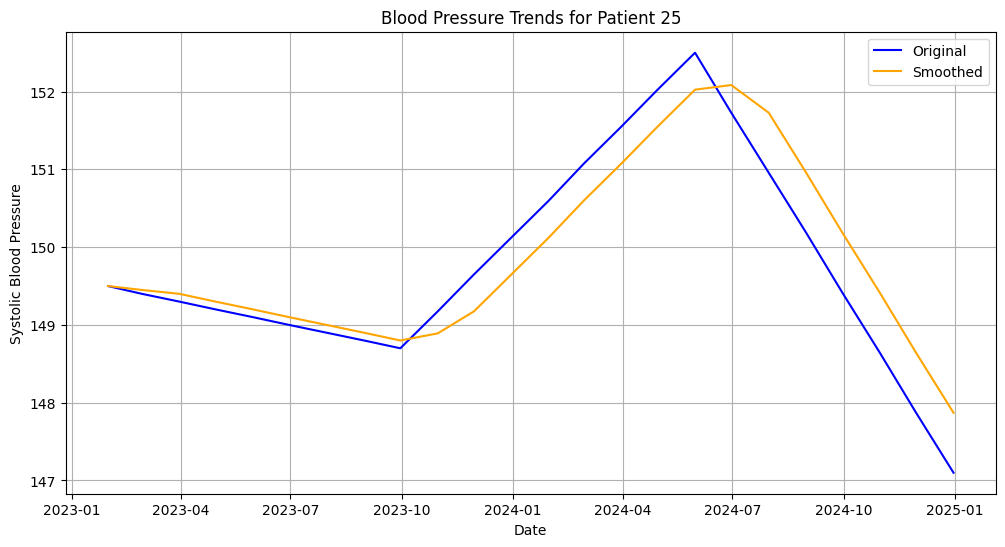

In [20]:
# Example: Selecting a single patient to analyze their blood pressure trend
patient_id = 25
patient_data = clean_long_df.loc[patient_id, 'bp_systolic']

# Resample data to a monthly frequency using mean aggregation
monthly_bp = patient_data.resample('M').mean()

# Fill any missing monthly values using interpolation
monthly_bp = monthly_bp.interpolate(method='linear')

# Calculate 3-month moving average for smoothing
smoothed_bp = monthly_bp.rolling(window=3, min_periods=1).mean()

# Optional: Calculate an exponentially weighted moving average
ewm_bp = monthly_bp.ewm(span=3, adjust=False).mean()

# Plotting the results
plt.figure(figsize=(12, 6))

# Original monthly trend
plt.plot(monthly_bp, label='Original', color='blue')
# Smoothed trend (3-month moving average)
plt.plot(smoothed_bp, label='Smoothed', color='orange')

# Labeling the plot
plt.title(f'Blood Pressure Trends for Patient {patient_id}')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure')
plt.legend()
plt.grid(True)
plt.show()

### Analysis
This plot illustrates the trend of systolic blood pressure for patient 25 from January 2023 to January 2025. The blue line indicates the original trend of blood pressure while the orange line, illustrates the smoothed line of blood pressure trend. As we can see, over time, the blood pressure decreases a little bit, increases, and the decreases a large amount.

## Statistical Model Tasks

### Factors affecting blood pressue
To find factors affecting blood pressure, we read in the patient_baseline.csv file. Since our target is the systolic blood pressure, we set that variable to y and set our predictors to X. Our predictors that we used are age, bmi, smoking, and diabetes. We then added a constant for the model to used for the intercept. For our model, we used the OLS model which is an ordinary least squares model that uses a linear regression to estimate the relationship between variables. To print our results and analysis, we used the summary() function, along with plotted the residuals and Q-Q plot to visualize the results.

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     149.1
Date:                Tue, 05 Nov 2024   Prob (F-statistic):          6.36e-100
Time:                        09:42:40   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.979     54.812      0.0

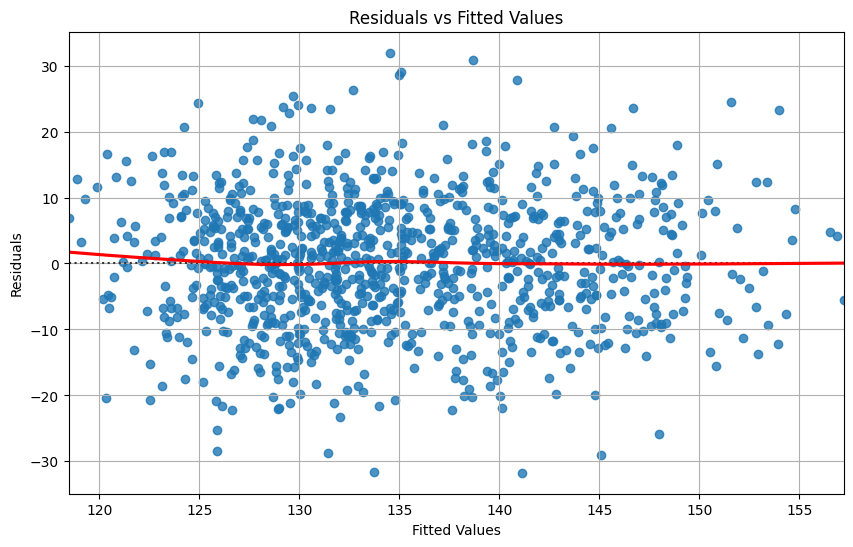

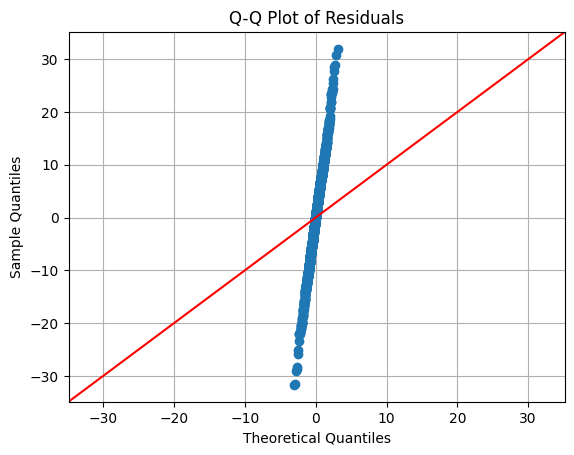

In [22]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

base_df = pd.read_csv("patient_baseline.csv", sep="\t") # read in csv

y = base_df['bp_systolic'] # target
X = base_df[['age', 'bmi', 'smoking', 'diabetes']] # predictors

# Add a constant to the model for the intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit(cov_type='HC3')  # Using robust standard errors (HC3)

print(model.summary()) # print summary

# create figure
plt.figure(figsize=(10, 6))

# residual plot
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values') # name x label
plt.ylabel('Residuals') # name y label
plt.title('Residuals vs Fitted Values')
plt.grid(True) # plot the grid lines
plt.show()

# Q-Q plot
sm.qqplot(model.resid, line='45')
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.show()

Our OLS regression has an R-squared value of 0.376. This means that the fit of our model is not good. As illustrated from the residual plot, because the points are randomly scattered, this shows us that a linear regression would be a good choice for our model. The QQ plot tells us that our residuals are normally distributed. In addition, since we have low p-values for age, bmi, smoking, and diabetes, this tells us that it is highly significant. Simiarly, the narrow range in the 95% confidence interval tells us that there is a strong association between the variables and our target variable.

### Model Treatment Effectiveness
To determine the model treatment effectiveness, we first read in the patient_treatment.csv file. Our target is the outcome and the predictors that we used are age, bmi, smoking, diabetes, systolic blood pressure, cholesterol, heart rate, and adherence.We then fit a GLM with binomial family. To print out the results, we used the summary() function, along with calcualted the odds ratios and plotted residual plots and Q-Q plots to visualize the data.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      991
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -642.39
Date:                Tue, 05 Nov 2024   Deviance:                       1284.8
Time:                        10:22:23   Pearson chi2:                     997.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04877
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.3849      1.250     -3.507      

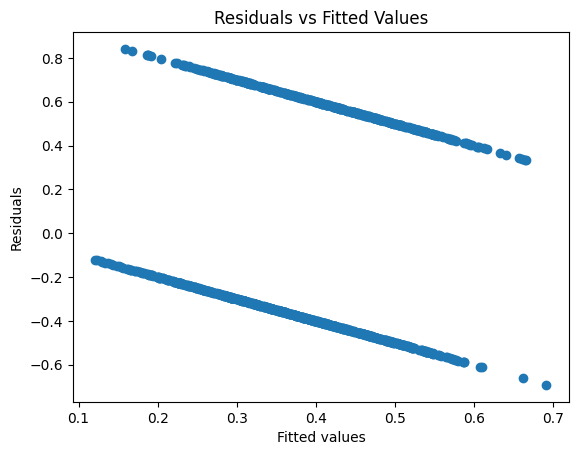

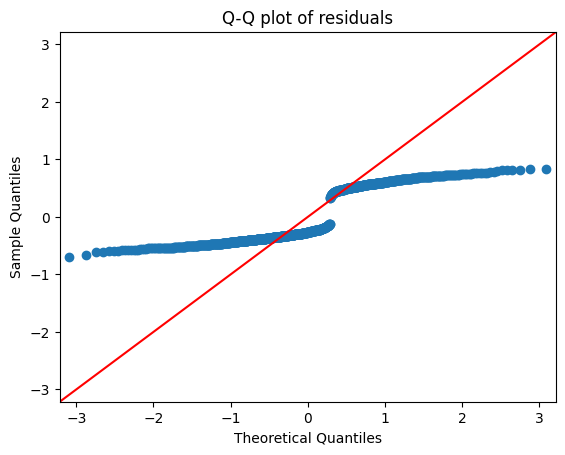

In [28]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

treat_df = pd.read_csv("patient_treatment.csv", sep="\t")

X = treat_df[['age', 'bmi', 'smoking', 'diabetes', 'bp_systolic','cholesterol','heart_rate', 'adherence']]
X = sm.add_constant(X)  # Add intercept
y = treat_df['outcome']

# Fit GLM with binomial family
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# Print the model summary
print(model.summary())

odds_ratios = np.exp(model.params)  # Odds ratios
conf_int = np.exp(model.conf_int())  # Confidence intervals for odds ratios
conf_int.columns = ['Lower', 'Upper']

print("Odds Ratios:\n", odds_ratios)
print("\nConfidence Intervals for Odds Ratios:\n", conf_int)

print() #print empty line

# print model deviance
print("Null Deviance:", model.null_deviance)
print("Residual Deviance:", model.deviance)

# residuals vs fitted values
plt.scatter(model.fittedvalues, model.resid_response)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Q-Q plot
sm.qqplot(model.resid_response, line='45')
plt.title('Q-Q plot of residuals')
plt.show()


In this statistical model, we used baseline characteristics (age, sex, bmi, smoking, diabetes, systolic blood pressure, cholesterol, and heart rate) as predictors to predict our outcome. The odds ratios tell us that patients with diabetes have a lower chance of having a successful outcome. The confidence interval for diabetes also does not include 1, which indicates that having diabetes significantly reduces the odds of treatment success. In addition, there is an inverse relationship between smoking and outcome as illustrated by the odds ratio. Since the ratio is 0.772, this suggets taht smoking is associated with lower odds of treatment success. The wider range of the confidence interval means that we cannot determine if smoking significantly affects treatment success. The odds ratio between adherence and outcome is very high, making it the most significant variable. The odds ratio of 7.522 illustrates that patients with high adherence to medication will have a much higher odds of a successful outcome. Adherence also has a very large confidence interval ranging from 2.01 to 28.12, which means that higher adherence significantly increases the odds of success. 

The null devience tells us how well the simplest model fits the data. Since this value is very high at 1334.77, this means that there is a lot of variability. The residual deviance is 1284.78, which tells us that our model does not fit the data avery well because it is so high. A lower residual deviance indicates a better fit to the data. 

In our residual plot, we have two lines that are formed with a decreasing trend. This illustrates that there are 2 groups (which makes sense because we have a binary outcome) and that the relationship between predictors and the outcome are not strictly linear. In addition, our qq plot shows a non-linear trend, which illustrates taht the residuals do not follow a normal distribution.

## Machine Learning Task

### Prediction Pipeline Code
To create a prediction pipeline, we first read in the patient_treatment.csv file and set our variables to the target and the predictors. Then, we split our dataset into our training and our testing dataset. We standardized the numeric features and used a one hot encoder for the categorical variables. Then, we created a pipeline with specific components, which we then used to fit the data. To determine the accuracy of our model, we then printed a classification report and confusion matrix. Finally, we created an ROC curve plot to illustrate the area under the curve.

Cross-validation scores:
Accuracy: 0.574 ± 0.032
Precision: 0.460 ± 0.034
Recall: 0.587 ± 0.078
ROC AUC: 0.619 ± 0.053

Confusion Matrix:
[[90 94]
 [49 67]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.49      0.56       184
           1       0.42      0.58      0.48       116

    accuracy                           0.52       300
   macro avg       0.53      0.53      0.52       300
weighted avg       0.56      0.52      0.53       300



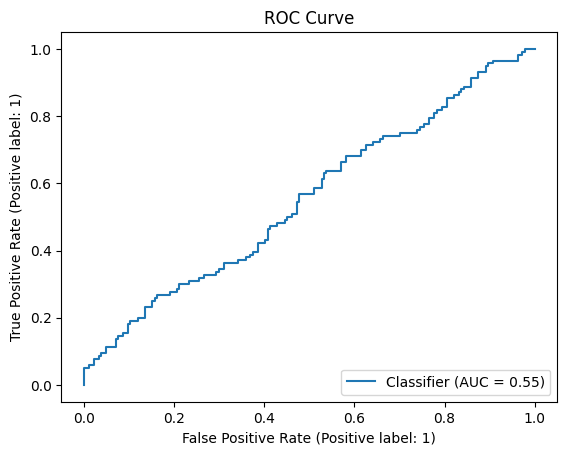

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold,
    cross_validate
)
from sklearn.metrics import (
    classification_report,
    RocCurveDisplay,
    confusion_matrix
)

treat_df = pd.read_csv("patient_treatment.csv", sep="\t") # read in csv file

feature_cols = ['age', 'bmi', 'smoking', 'diabetes', 'bp_systolic', 'cholesterol', 'heart_rate', 'adherence']
X = treat_df[feature_cols]
y = treat_df['outcome']  # Assuming 'outcome' is the binary target variable for treatment success

# Create a ColumnTransformer to preprocess features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Standard scaling for numeric features
        ('cat', OneHotEncoder(), categorical_features)  # One-hot encoding for categorical features
    ]
)

# Create pipeline with specific components
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    )
)

# divide 70 training, 30 testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y,
    random_state=42
)

# ross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)


# Print cross-validation results
print("Cross-validation scores:")
print(f"Accuracy: {np.mean(scores['test_accuracy']):.3f} ± {np.std(scores['test_accuracy']):.3f}")
print(f"Precision: {np.mean(scores['test_precision']):.3f} ± {np.std(scores['test_precision']):.3f}")
print(f"Recall: {np.mean(scores['test_recall']):.3f} ± {np.std(scores['test_recall']):.3f}")
print(f"ROC AUC: {np.mean(scores['test_roc_auc']):.3f} ± {np.std(scores['test_roc_auc']):.3f}")

# Fit the model on the entire training set for final evaluation
pipeline.fit(X_train, y_train)

# Predictions on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title(f'ROC Curve')
plt.show()

### Analysis
From the results, we can determine that our model is not doing very well. With an accuracy of 57.4% and ROC AUC of 0.619. These values are low, indiciating that the model is not correctly making predictions based upon the data that we have. In addition, the confusion matrix indicates that the model struggles with both false positives and false negative. In addition, there is a low precision that indicates the difficulty with distinguishing true positives accurately. The ROC graph additionally indicates that the model is not very good at telling the difference between positive and negative classes. With the cross validation, relative to the first model, this one did better, as illustrated by the higher accuracy and area under the curve.